    
## DLT and Epipolar Lines

Using the direct linear transform to find the camera intrinsics as well as extrinsics (P matrix) by finding 2D-3D correspondances. 

We also visualise epipolar lines (generated on applying techniques of epipolar geometry) on an image pair.


---

### Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.


Given 3D, 2D (World - image plane {pixel} coordinates) we have to estimate the intrinsic and extrinsic properties of a camera.

#### What do we have?
We know that 

$$x_{3 \text{x} 1} = P_{3 \text{x} 4}X_{4 \text{x} 1}$$

Where we're following the convention used in class. x denotes the Image-Plane (pixel) coordinates and X denotes the World-Frame coordinates. P is our transformation matrix that takes the world frame homogenous coordinates and gives us the image plane homogenous coordinates.

$$
P_{3 \text{x} 4} = K_{3 \text{x} 3}R_{3 \text{x} 3} \begin{bmatrix}
\text{I}_{3} | -X_{0}
\end{bmatrix} 
$$

Where K is our camera intrinsic matrix, R is the rotation matrix of the camera with respect to the world frame. $X_{0}$ is the translation between the origins of the camera frame and the world frame. 

\subsection{How many points do we need?}
The P matrix has 12 variables, we only need to solve for 11 variables as the matrix is homogenous ($\lambda X = X$) 
Now the natural question to ask is how many equations does each correspondance gives rise to. Each correspondance gives us 2 equations, that means to solve for 11 variables, we need 6 correspondances. These 6 points should not all lie on a plane as we'll see later.

#### Modelling the problem

$$
x_{i} = PX_{i} $$ $$\hspace{1.25cm} = \begin{bmatrix}
A^{T} \\
B^{T} \\
C^{T}
\end{bmatrix} X_{i}  
$$
$$
\hspace{1.25cm} = \begin{bmatrix}
A^{T}X_{i} \\
B^{T}X_{i} \\
C^{T}X_{i}
\end{bmatrix}
$$

$$ \hspace{0.75cm}
 = \begin{bmatrix}
 u_{i} \\
 v_{i} \\
 w_{i} 
 \end{bmatrix}
$$
$$
x_{i} = \frac{u_{i}}{w_{i}} = \frac{A^{T}X_{i}}{C^{T}X_{i}}
$$
$$
y_{i} = \frac{v_{i}}{w_{i}} = \frac{B^{T}X_{i}}{C^{T}X_{i}}
$$
$$
\Rightarrow x_{i}C^{T}X_{i} = A^{T}X_{i}
$$
$$
\Rightarrow y_{i}B^{T}X_{i} = B^{T}X_{i}
$$
$$
\Rightarrow -A^{T}X_{i} \hspace{1.3cm} + x_{i}C^{T}X_{i} = 0
$$
$$
\Rightarrow \hspace{1.3cm} -B^{T}X_{i} + y_{i}B^{T}X_{i} = 0
$$

Let us now define a vector P as below

$$
P = \begin{bmatrix}
A \\
B \\
C \\
\end{bmatrix}_{12 \text{x} 1}
$$

This is the transformation matrix row-flattened. We can now write the above two expressions as a matrix multiplication with our column vector P. For each point (indexed by i) we can define two row-vectors as follows:

$$
a_{xi}^{T}P = [-X_{i}, -Y_{i}, -Z_{i}, -1, 0, 0, 0, 0, x_{i}X_{i}, x_{i}Y_{i}, x_{i}Z_{i}, x_{i}]_{1 \text{x} 12}P_{12 \text{x} 1} = 0
$$
$$
a_{yi}^{T}P = [0, 0, 0, 0, -X_{i}, -Y_{i}, -Z_{i}, -1, y_{i}X_{i}, y_{i}Y_{i}, y_{i}Z_{i}, y_{i}]_{1 \text{x} 12}P_{12 \text{x} 1} = 0
$$

When we have multiple correspondances we simply stack the points in the above format to create a matrix ${M}$ of dimension ${2i}$x${12}$. So for 'i' points we have:

$$
M_{2i \text{x} 12}P_{12 \text{x} 1} = 0
$$

Unfortunately, we encounter noise in our measurements of coordinates be it the ones in the image-plane or the world-frame. So the above over-determined system (if we have more equations than variables) will not equate to zero but a small value we'll consider to be ${w}$.
\\*
We want to reduce this value with respect to the constraint $ \|P\|$ = 1.

We impose this constraint as ${P}$ is homogenous (as defined above) and we want to solve for it.

We take the SVD (Singular Value Decomposition) of the matrix M and its smallest eigenvalue which corresponds to the smallest eigenvector. We take this as we want to minimise ${w}$ as defined above. The given homogenous system of equations isn't guaranteed to have 0 as an eigenvalue (because of noise in readings), thus we want to take the smallest possible eigenvalue, resulting in us resorting to using the SVD.
\\*
We now have the P vector which can be reshaped into the desired 3x4 matrix. This matrix is now decomposed into K, R and T.

#### Decomposing P
Let:
$$
P = KR\begin{bmatrix}
I|-X0
\end{bmatrix}
= 
\begin{bmatrix}
KR|-KRX0
\end{bmatrix}   
=
\begin{bmatrix}
H|h
\end{bmatrix}   
$$
To solve for T which is denoted as ${X0}$
$$
H^{-1}H = -(KR)^{-1}(KR)(-X0) = X0  
$$
We know the QR matrix decomposition technique which decomposes a matrix into a matrix with orthonormal columns and an upper triangular matrix. We know that R is our rotation matrix which has a property that its columns are orthonormal. K is the camera calibration matrix (the matrix of intrinsic parameters) and it has the property of being upper triangular. Sadly, our H is given by KR which is not of the form we want. Thus we invert H such that on decomposition it yields a matrix with orthonormal columns and an upper triangular matrix. We can do this as the inverse of R is nothing but its transpose, the inverse of an upper triangular matrix is also upper triangular. Thus, $H^{-1}$ decomposes into:
$$
H^{-1} = R^{-1}K^{-1} = R^{T}K^{-1}
$$

Hence we have solved for our unknowns which are K, R and T.

In [3]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [4]:
image_points = []
fig = plt.figure(figsize=(20,30))

img=mpimg.imread('Images/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

[[350.65687571 507.07838496]
 [439.02146428 444.613762  ]
 [516.72136112 386.71972122]
 [571.56834713 337.96684476]
 [349.13334832 596.96650091]
 [343.03923877 676.18992515]
 [347.60982093 735.60749332]
 [429.88029994 537.54893274]
 [503.00961462 473.56078239]
 [257.72170498 548.21362446]
 [173.92769857 485.74900151]
 [341.51571138 389.76677599]
 [425.30971778 337.96684476]
 [332.37454704 292.26102309]
 [257.72170498 337.96684476]]


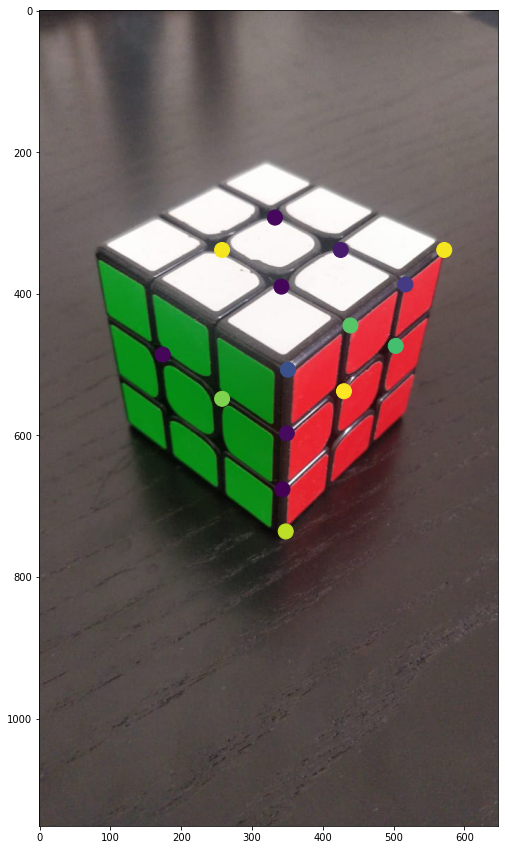

In [5]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
print(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('./Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [6]:
#We'll rename image_points to x to match textbook convention
x = image_points
# X represents the 3D world points
X = []
#Add your points here
#Add them as 3D points only
#Below are the 3D points taken with respect to the frame taken at the intersection of the white, red and green faces.
#The x-axis is along the intersection of the white-red planes.
#The y-axis is along the intersection of the white-green planes.
#The -ve z-axis is along the intersection of the green-red planes.
X.append([0,0,0])
X.append([4/300, 0, 0])
X.append([8/300, 0, 0])
X.append([4/100, 0, 0])
X.append([0, 0, -4/300])
X.append([0, 0, -8/300])
X.append([0, 0, -4/100])
X.append([4/300, 0, -4/300])
X.append([8/300, 0, -4/300])
X.append([0, 4/300, -4/300])
X.append([0, 8/300, -4/300])
X.append([4/300, 4/300, 0])
X.append([8/300, 4/300, 0])
X.append([8/300, 8/300, 0])
X.append([4/300, 8/300, 0])

#The scaling factor doesn't play a role when converting into homogenous coordinates.

X = np.array(X)
print(X.shape)
print(X)
print(x)
#X = np.array(X)

(15, 3)
[[ 0.          0.          0.        ]
 [ 0.01333333  0.          0.        ]
 [ 0.02666667  0.          0.        ]
 [ 0.04        0.          0.        ]
 [ 0.          0.         -0.01333333]
 [ 0.          0.         -0.02666667]
 [ 0.          0.         -0.04      ]
 [ 0.01333333  0.         -0.01333333]
 [ 0.02666667  0.         -0.01333333]
 [ 0.          0.01333333 -0.01333333]
 [ 0.          0.02666667 -0.01333333]
 [ 0.01333333  0.01333333  0.        ]
 [ 0.02666667  0.01333333  0.        ]
 [ 0.02666667  0.02666667  0.        ]
 [ 0.01333333  0.02666667  0.        ]]
[[350.65687571 507.07838496]
 [439.02146428 444.613762  ]
 [516.72136112 386.71972122]
 [571.56834713 337.96684476]
 [349.13334832 596.96650091]
 [343.03923877 676.18992515]
 [347.60982093 735.60749332]
 [429.88029994 537.54893274]
 [503.00961462 473.56078239]
 [257.72170498 548.21362446]
 [173.92769857 485.74900151]
 [341.51571138 389.76677599]
 [425.30971778 337.96684476]
 [332.37454704 292.26102309]


Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [7]:
#Helper functions
#appends a ones column to input
def hom_coords(x,X):
    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate(
        (x,ones),
        axis = 1)
    X = np.concatenate(
        (X,ones),
        axis = 1)
    return x, X

print(x[1].shape, X[1].shape)
x,X = hom_coords(x,X)
print(x[1].shape, X[1].shape)

(2,) (3,)
(3,) (4,)


#### Explanation


In [8]:
#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
def DLT(x,X):
    
    #P = np.random.randn(3,4) no.
    
    #We know that for a single correspondance we get 2 equations, they are:
    #a_{x_{i}}^{T} . P = 0 and a_{y_{i}}^{T} . P = 0 where P is a matrix of dimensions 12x1 which is a "row-stacked" vector of the P we need to find. 

    correspondances = len(x)        
    for i in range(correspondances):
        if i == 0:
            print(-X[i][3])
            M = np.array([-X[i][0], -X[i][1], -X[i][2], -X[i][3], 0, 0, 0, 0, x[i][0] * X[i][0], x[i][0] * X[i][1], x[i][0] * X[i][2], x[i][0] * X[i][3]])
            M = np.vstack((M, [0, 0, 0, 0, -X[i][0], -X[i][1], -X[i][2], -X[i][3], x[i][1] * X[i][0], x[i][1] * X[i][1], x[i][1] * X[i][2], x[i][1] * X[i][3]]))
        else:
            M = np.vstack((M, [-X[i][0], -X[i][1], -X[i][2], -X[i][3], 0, 0, 0, 0, x[i][0] * X[i][0], x[i][0] * X[i][1], x[i][0] * X[i][2], x[i][0] * X[i][3]]))
            M = np.vstack((M, [0, 0, 0, 0, -X[i][0], -X[i][1], -X[i][2], -X[i][3], x[i][1] * X[i][0], x[i][1] * X[i][1], x[i][1] * X[i][2], x[i][1] * X[i][3]]))
    
    #As we have 15 points, we get an overdetermined system.
    #Sadly, we know that M.P will not be zero as there is noise in our readings. So we equate M.P to some variable w which is what we want to minimise subject to the constraint norm(P) = 1.
    #So the P we desire can be computed by the expression argmin(p) w^{T}.w. The SVD of M will give us the vector that minimises the equation. This vector is the last column of V
    u, d, vt = np.linalg.svd(M, full_matrices = True)  
    #print(u.shape, d.shape, v.shape)
    #print(d)
    P = vt[-1].reshape(3,4)
    #The last column of vt is the eigenvector corresponding to the last eigenvalue.
    P = P/P[2][3]
    print(P.shape)
    return P
    #return 0


#print(X.shape)
#print(X[0][3])
P = DLT(x,X)
print(P.shape)

-1.0
(3, 4)
(3, 4)


## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [9]:
#Get reprojected points
def get_points(P,X):
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    points,_ = hom_coords(points,x)
    print(points)
    print(x)
    err = np.mean((points - x) ** 2)
    #to err is to human
    print(err)
    return err
get_err(x,X,P)

[[350.88252542 509.92916208   1.        ]
 [439.44561451 442.6586296    1.        ]
 [513.57824378 386.34915016   1.        ]
 [576.54166545 338.52354983   1.        ]
 [349.26720813 601.47350664   1.        ]
 [347.96182844 675.45285973   1.        ]
 [346.88499161 736.48007855   1.        ]
 [429.31367023 533.44326971   1.        ]
 [497.49630328 475.49591565   1.        ]
 [257.98705678 542.89220838   1.        ]
 [172.66279582 488.13325031   1.        ]
 [343.34909247 388.43156475   1.        ]
 [422.71673595 338.182254     1.        ]
 [337.43005852 292.97064973   1.        ]
 [253.63680757 337.80711146   1.        ]]
[[350.65687571 507.07838496   1.        ]
 [439.02146428 444.613762     1.        ]
 [516.72136112 386.71972122   1.        ]
 [571.56834713 337.96684476   1.        ]
 [349.13334832 596.96650091   1.        ]
 [343.03923877 676.18992515   1.        ]
 [347.60982093 735.60749332   1.        ]
 [429.88029994 537.54893274   1.        ]
 [503.00961462 473.56078239   1. 

5.229170164209073

Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [10]:
def ret_RKT(P):
    
    H = P[0:3, 0:3]   # H = KR
    h = -P[:,-1]  # h = -KRX0

    T = np.linalg.inv(H)@h # - (KR)^{1}@{- KRX0} = X0 
    # X0 is the projection center.
    #this is the last column of P
    
    #We know that H = KR, where K is the camera matrix and is conveniently upper traingular. R is a rotation matrix with orthonormal columns.
    #R having orthonormal columns means that its inverse is nothing but the transpose of the matrix.
    #K being upper triangular means that its inverse will also be upper traingular.
    
    #The QR decomposition returns an orthonormal matrix and an upper trianglular matrix in that order.
    #The QR decomposition of H^{-1} will give us matrices in that order as H^{-1} = K^{-1}@K^{-1}
    
    Rinv, Kinv = np.linalg.qr(np.linalg.inv(H))
    
    R = Rinv.T
    K = np.linalg.inv(Kinv)
    #np.allclose()
    
    return R, K , T 

rotationMatrix, cameraIntrinsics, translation = ret_RKT(P)
cameraIntrinsics = cameraIntrinsics/cameraIntrinsics[2][2]
#Normalising to get 1.

print(f" The rotation matrix (R) is \n {rotationMatrix} \n The camera instrinsics matrix (K) is \n {cameraIntrinsics} \n The translation vector is \n {translation}")

 The rotation matrix (R) is 
 [[-0.52129958  0.83988038 -0.15115452]
 [-0.59220124 -0.48357155 -0.64455896]
 [-0.61444645 -0.24649442  0.74946385]] 
 The camera instrinsics matrix (K) is 
 [[ 882.23481035   47.86569006  554.75859861]
 [  -0.         -888.85124423  608.16144744]
 [   0.            0.            1.        ]] 
 The translation vector is 
 [-0.04682652 -0.04200836  0.06010639]


Reproject the world points with P matrix you have obtained via DLT:

(30,)
(30,)


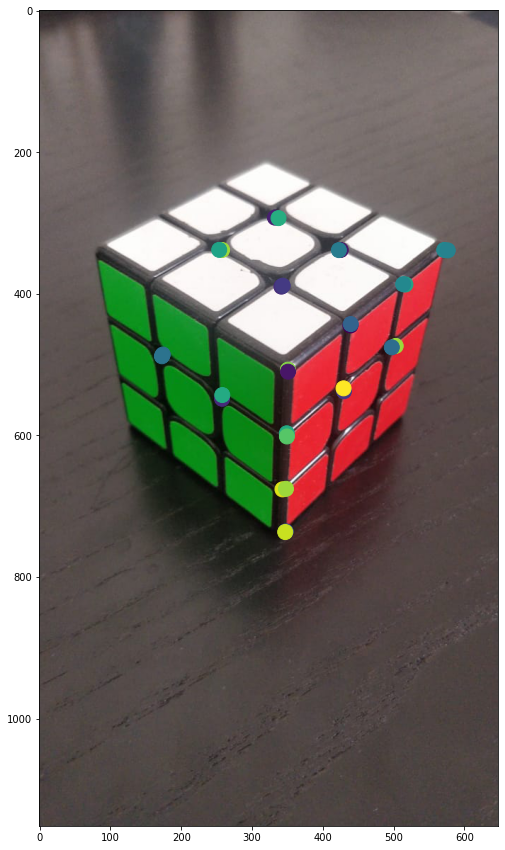

In [11]:
re_proj = get_points(P, X)
#code to plot these on the image
#concatenating re_proj and our initial X to a single x, y, axis vector to plot on the image.
re_proj = np.array(re_proj).astype('float32')
reProjX = re_proj[ : , 0]
reProjY = re_proj[ : , 1]
initialX = x[ : , 0]
initialY = x[ : , 1]

finalX = np.hstack((initialX, reProjX))
finalY = np.hstack((initialY, reProjY))

%matplotlib inline
N = len(finalX)
#image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 
print(finalX.shape)
print(finalY.shape)
plt.scatter(finalX[ : ], finalY[ : ], c = colors, s = area)
plt.show()

---
### Epipolar lines

We are given two images of the same scene taken from different view-points. The fundamental matrix that encodes their relative geometry as well as a subset of corresponding points are provided. The images are in the folder q2 .

Given a point in one image, its corresponding location in the other image can be found to along a line viz. the epipolar line. We will draw the epipolar lines in the second image for each given point in the first image. We repeat this for the other image as well. 

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image.

In [15]:
data_file = "q2/data.txt"

with open(data_file, 'r') as f:
    A = f.readlines()
    
img_points1 = A[2:12]
img_points1 = [i.strip()[:-1] for i in img_points1]
img_points1[0] = img_points1[0][1:]
img_points2 = A[15:25]
img_points2 = [i.strip()[:-1] for i in img_points2]
img_points2[0] = img_points2[0][1:]

F_mat = A[28:31]
F_mat = [i.strip()[:-1] for i in F_mat]
F_mat[0] = F_mat[0][1:]

img_1 = []
img_2 = []
F_MAT = []

for i in img_points1:
    img_1.append(np.fromstring(i[1:-1], sep=' '))
    
for i in img_points2:
    img_2.append(np.fromstring(i[1:-1], sep=' '))
    
for i in F_mat:
    F_MAT.append(np.fromstring(i[1:-1], sep=' '))

img_1 = np.array(img_1)
img_2 = np.array(img_2)
F_mat = np.array(F_MAT)

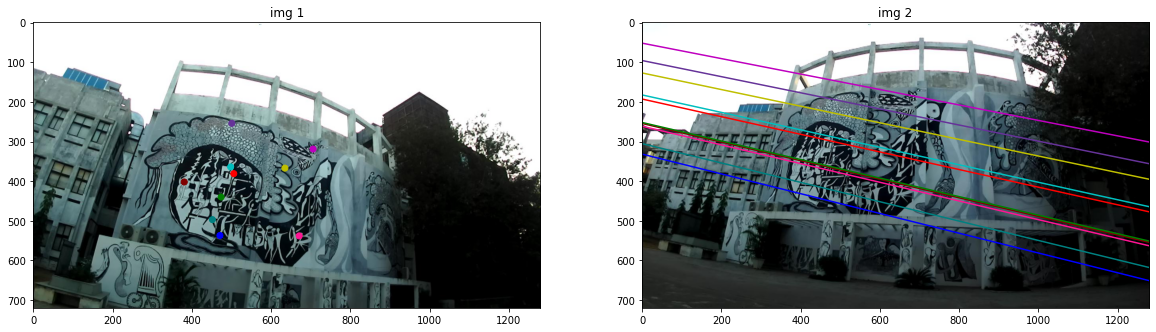

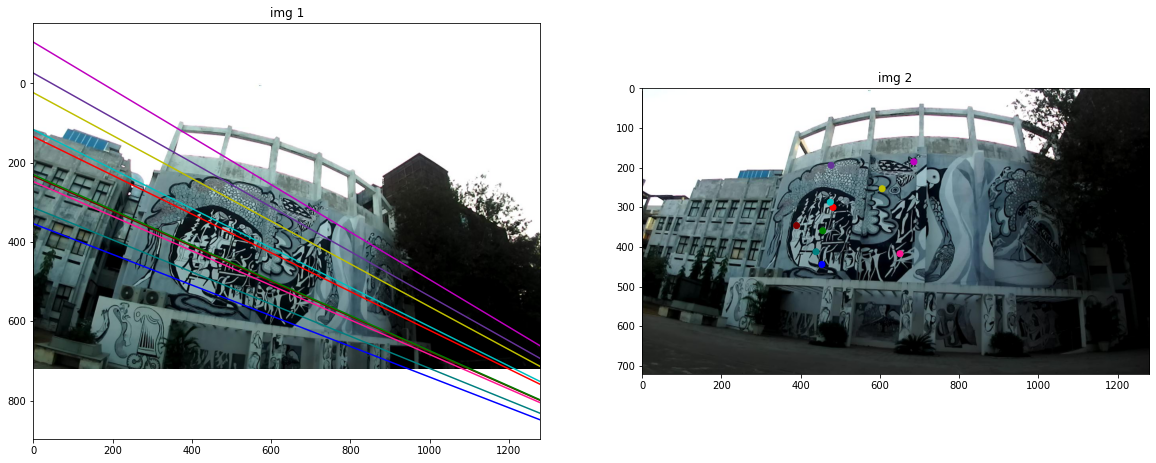

In [16]:
#Write code to plot epipolar lines on the images
%matplotlib inline
img_1_homo, img_2_homo = hom_coords(img_1, img_2)
lines_2 = F_mat @ img_1_homo.T
lines_1 = F_mat.T @ img_2_homo.T


def plot1(line):
    
    im1 = mpimg.imread('q2/img1.jpg')
    im2 = mpimg.imread('q2/img2.jpg')
    
    colors_list = ['#800000', '#008080', '#ff1493', '#663399','r', 'g', 'b', 'c', 'm', 'y']
    
    fig = plt.figure(figsize=(20,9))
    ax1 = fig.add_subplot(121)
    ax1.imshow(im1)
    ax1.scatter(img_1[:, 0], img_1[:, 1], c = colors_list)
    ax1.set_title('img 1')
    
    ax2 = fig.add_subplot(122)
    ax2.imshow(im2)
    for i in range(line.shape[1]):
        x_vals = np.array(ax2.get_xlim())
        slope = - line[:,i][0]/line[:,i][1]
        intercept = -line[:,i][2]/line[:,i][1]
        y_vals = intercept +slope * x_vals
        ax2.plot(x_vals, y_vals, colors_list[i])
    ax2.set_title('img 2')
    plt.show()
def plot2(line):
    
    im1 = mpimg.imread('q2/img1.jpg')
    im2 = mpimg.imread('q2/img2.jpg')
    
    colors_list = ['#800000', '#008080', '#ff1493', '#663399','r', 'g', 'b', 'c', 'm', 'y']
    fig = plt.figure(figsize=(20,9))
    ax1 = fig.add_subplot(121)
    ax1.imshow(im1)
    for i in range(line.shape[1]):
        x_vals = np.array(ax1.get_xlim())
        slope = - line[:,i][0]/line[:,i][1]
        intercept = -line[:,i][2]/line[:,i][1]
        y_vals = intercept +slope * x_vals
        ax1.plot(x_vals, y_vals, colors_list[i])
    ax1.set_title('img 1')
    
    
    ax2 = fig.add_subplot(122)
    ax2.imshow(im2)
    ax2.scatter(img_2[:, 0], img_2[:, 1], c = colors_list)
    ax2.set_title('img 2')
    
    
    plt.show()
    
# plz run the following to get plots
plot1(lines_2)

plot2(lines_1)


Epipolar lines can be found by multipying Fundamental matrix (F) with image point coordinates. <br>

line in image1 is given as: $line1 = F * imgPoints2$ <br>
line in image1 is given as: $line2 = F^{T} * imgPoints1$ <br>
This happens because the image points lie on epipolar lines <br>
Exploiting the coplanarity constraint for image points  we get: <br> 
$imgPoints1^{T} * F * imgPoints2 = 0$ <br>
<br>
The above equation holds if:
<br>
$line1 = F * imgPoints2$ 
<br>
$line2 = F^{T} * imgPoints1$
<br>
as <br> $imgPoints1^{T} * line1 = 0$ and <br>
$imgPoints2^{T} * line2 = 0$


The location of the epipole for the first image plane can be calculated as the left nullspace of the fundamental matrix $F$, that is equivalent to the right nullspace of $F^{T}$. The location for the epipole of the second image is given by the right nullspace of the fundamental matrix. We obtain the eigenvector corresponding to the zero eigenvalue by searching for the 0 eigen value in the diagonal matrix obtained on doing SVD and we take the corresponding row in V. In both cases, the last eigenvalue had a value 0.

In [17]:
F = F_MAT
u, d, v = np.linalg.svd(F)
#print(u.shape, d.shape, v.shape)
#print(d)
e2 = v[-1]
#print(e2)
e2 = e2/e2[2]
#print(e2 := e2/e2[2])
F = np.array(F).reshape(3,3)
#print(F)

F = F.transpose()
#print(F)
U, D, V = np.linalg.svd(F)
e1 = V[-1]
e1 = e1/e1[2]
#print(e1 := e1/e1[2])
#print(e2, e1)
#print(U.shape, D.shape, VT.shape)
#print(D)
#print(e1.dtype)
print(f" The location of the epipole in the first image plane is {e1[0]},{e1[1]}. \n The location of the epipole in the second image plane is {e2[0]},{e2[1]}.")

 The location of the epipole in the first image plane is -5131.9096383781325,-948.8546306591447. 
 The location of the epipole in the second image plane is 2159.1662830647083,1189.268100283872.
